# Exploring some LOFAR data in Jupyter notebook

In this notebook we will be exploring some LOFAR data. LOFAR is a radio interferometer, i.e. all stations record the signal from a given direction and from the interference of that signal an image can be produced.

There are a few things for which the instruments needs to be calibrated. That is done by pointing the telescope at a well-known source (in this case 3C196) and comparing the measured data with the expected data.

We will explore some calibration solutions, which are stored in an HDF5 file.


Please download the file `test.h5` from http://www.astron.nl/citt/test.h5 and store it in a place you can remember.

## Initialize and check environment

In [1]:
import sys

In [2]:
sys.executable

'/anaconda/envs/school18/bin/python'

The above line should mention that you're running python from the `school18` environment

## Open the solution file

In [3]:
import h5py

/anaconda/envs/school18/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
h5py.__file__

'/anaconda/envs/school18/lib/python3.6/site-packages/h5py/__init__.py'

The above line should mention that you're running the `h5py` from the `school2018` environment

In [5]:
import numpy as np

Let's open the HDF5 file with LOFAR calibration solutions (change the path to the place where the file is).

In [25]:
h5filename = '/Users/dijkema/Desktop/test.h5'

In [26]:
h5file = h5py.File(h5filename, mode='r')

All solutions are stored inside the group '`sol000`', so let's make a shortcut there.

In [27]:
sol = h5file['sol000']

In [28]:
list(sol.keys())

['amplitude000', 'antenna', 'phase000', 'source']

With the `keys()` function of an HDF group, you can explore its children. It's a hierarchical format, so those children can have children as well. `h5py` comes with a handy function `visit` to call a function on all items of a file. (Note that it's useful here that `print` is just a function like any other function).

In [29]:
sol.visit(print)

amplitude000
amplitude000/ant
amplitude000/freq
amplitude000/pol
amplitude000/time
amplitude000/val
antenna
phase000
phase000/ant
phase000/freq
phase000/pol
phase000/time
phase000/val
source


A few words about the file format:
 * The `antenna` table contains metadata on the antennas (or actually antenna stations)
 * The tables `amplitude000/val` and `phase000/val` contain the actual calibration data, in a large cube (multi-dimensional array)
 * The other tables `amplitude/time`, `amplitude/ant`, `amplitude/freq`, , `amplitude/pol` contain the metadata for each of the axes of the data cube

You can access subgroups either by nesting squared brackets (i.e. `sol['amplitude000']['ant']`) or by using a slash (i.e. `sol['amplitude000/ant']).

## Plot antennas

In [30]:
antennadata = sol['antenna']

In [31]:
antennadata[0]

(b'CS001LBA', [ 6.8676305, 52.911396 , 50.16268  ])

An antenna consists of a tuple of its name and its coordinates (in the form longitude, latitude and elevatiom).

Note that the name `b'CS001LBA'` comes from the HDF5 as "bytes": python does not know yet which character set to use for these bytes. To convert it to a normal string, we need to tell python the character set used. Actually any character set will do here, since (almost) all character sets map 'normal' letters to the right thing (and LOFAR does not have stations called `CS00😇LBA`).

In [32]:
antenna_names = [antenna[0].decode('utf-8') for antenna in antennadata]

In [33]:
coords_latlon = np.array([antenna[1][1::-1] for antenna in antennadata])

With `folium` we can convert this list of coordinates into a nice leaflet map.

In [34]:
import folium

In [35]:
antennamap = folium.Map(location=[52.91494834, 6.86876941], zoom_start=16,
                        tiles='http://services.arcgisonline.com/arcgis/rest/services/World_Imagery/MapServer/MapServer/tile/{z}/{y}/{x}',
                        attr='ESRI')

for ant_num, coord_latlon in enumerate(coords_latlon):
    folium.Marker(coord_latlon, popup=antenna_names[ant_num]).add_to(antennamap)

In [266]:
antennamap

**Exercise**: Please explore this map a bit and appreciate the extent of LOFAR :)

## View a solution

Let's explore the solutions a bit.

In [37]:
import matplotlib.pyplot as plt

In [38]:
amplitude_sol = sol['amplitude000']

In [39]:
amplitude_sol.visit(print)

ant
freq
pol
time
val


In [40]:
sol['amplitude000/val']

<HDF5 dataset "val": shape (3, 35, 488, 2), type "<f8">

Let's now close the HDF5 file and load the data more properly. Keeping it open all the time can have disadvantages e.g. when the kernel crashes.

In [41]:
h5file.close()
del sol, h5file, amplitude_sol

**Exercise**: create a function `load_solution(h5filename, solution_name)` that extracts a data cube (no metadata yet) from the HDF5 file and returns a numpy array. Open and close the HDF5 file within this function.

**Hint**: to avoid not closing the file when an exception happens, use the construct "`with h5py.File(...) as h5file`". Use `.value` on the HDF node to get a numpy array.

In [43]:
def load_solution(h5filename, solution_name):
    with h5py.File(h5filename) as h5file:
        result = h5file['sol000/{}/val'.format(solution_name)].value
    return result

In [45]:
amplitude_values = load_solution(h5filename, "amplitude000")

In [46]:
amplitude_values.shape

(3, 35, 488, 2)

The axes of the data cube are, in order:
 * time: The time of the calibration, typically every 4 seconds
 * ant: Station name
 * freq: Frequency (in Hz)
 * pol: Polarization (linear, X or Y)

In [56]:
n_times, n_stations, n_freq, n_pol = amplitude_values.shape

**Exercise**: create functions `load_meta(h5filename, solution_name)` that returns a tuple of numpy arrays, i.e. `time, ant, freq, pol`, from the corresponding node in `h5file/sol000/solution000/xxx`.

In [47]:
def load_meta(h5filename, solution_name):
    with h5py.File(h5filename) as h5file:
        result = [h5file['sol000/{}/{}'.format(solution_name, axis_name)].value for axis_name in ['time', 'ant', 'freq', 'pol']]
    return result

In [48]:
meta_time, meta_station, meta_freq, meta_pol = load_meta(h5filename, "amplitude000")

Let's plot the bandpass of some station:

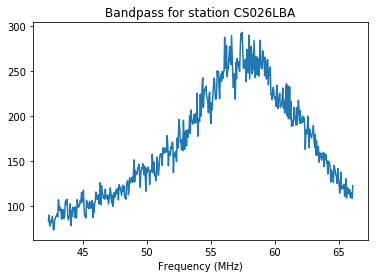

In [158]:
station_nr = 12
fig, ax = plt.subplots(1)
ax.plot(1.e-6 * meta_freq, amplitude_values[0, station_nr, :, 0])
ax.set_xlabel("Frequency (MHz)")
ax.set_title("Bandpass for station {station:}".format(
    station=meta_station[station_nr].decode('utf-8')));
del station_nr

## Class

The concept of a solution with different axes (each with their own metadata) is actually worth its own class. Let's create a class `Solution` with attributes `val`, `time`, `station`, `freq`, `pol`.

In [341]:
class Solution:
    def __init__(self, h5filename, solution_name):
        """Initialize the object
        
        Args:
            h5filename (str): filename (should be absolute)
            solution_name (str): name of solution, e.g. amplitude000
        """
        with h5py.File(h5filename) as h5file:
            self.val = h5file['sol000/{}/val'.format(solution_name)].value
            (self.time, self.station, self.freq, self.pol) = \
                 [h5file['sol000/{}/{}'.format(solution_name, axis_name)].value \
                  for axis_name in ['time', 'ant', 'freq', 'pol']]
            self.station = list(self.station.astype('|U8'))
            
            self.station_number = {self.station[station_num]: station_num
                  for station_num in range(len(self.station))}

**Exercise**: use this class to get a solution for `amplitude000`.

## Make the bandpass plot interactive

In [287]:
from ipywidgets import interactive, interact

In [288]:
amplitude_solution = Solution(h5filename, "amplitude000")

We'll use a dict "`station_number`" with the station names as key and their index in the array as values.

In [289]:
station_number = {meta_station[station_num]: station_num
                  for station_num in range(len(meta_station))}

**Exercise**: update the class `Solution` to have this dict as one of its members. You'll have to re-initialize `amplitude_solution`.

In [290]:
amplitude_solution.station_number['CS301LBA']

19

**Exercise**: create a function `plot_bandpass(time, station_name, pol)` that creates the right bandpass plot.

In [293]:
def plot_bandpass(time, station_name, pol):
    fig, ax = plt.subplots(1)
    ax.plot(1.e-6 * meta_freq, amplitude_values[time, amplitude_solution.station_number[station_name], :, pol], '.')
    ax.set_xlabel("Frequency (MHz)")
    ax.set_title("Bandpass for station {}".format(station_name));

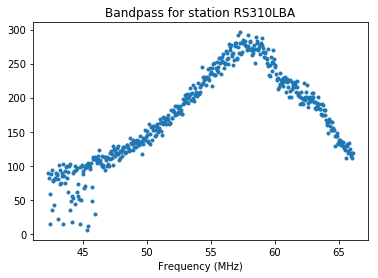

In [294]:
plot_bandpass(2, 'RS310LBA', 0)

**Exercise**: create an interactive widget for the bandpass plot that shows a dropdown for the station name, a slider for the time and a dropdown for the polarization.

In [342]:
interactive(plot_bandpass,
            station_name=amplitude_solution.station,
            time=(0, len(amplitude_solution.time)-1),
            pol=[0,1])

interactive(children=(IntSlider(value=1, description='time', max=2), Dropdown(description='station_name', opti…

## Read in phase values

In [306]:
phase_solution = Solution(h5filename, 'phase000')

In [307]:
phase_values = phase_solution.val

In [308]:
phase_values.shape

(200, 35, 488, 2)

In [309]:
n_times, n_stations, n_freq, n_pol = phase_solution.val.shape

The phases are only meaningful when a phase reference is chosen; let's choose the first station as the phase reference.

In [310]:
phase_values = phase_values[:, :, :, :] - phase_values[:, 0, :, :][:, np.newaxis, :, :]

For some physical reasons, the phase solutions for these calibration values wrap at $\pi$ (not $2\pi$ as all other phases do). We constrain all values between $-\pi/2$ and $\pi/2$.

In [311]:
def constrain_pi(a):
    """Constrain numbers between -pi/2 and pi/2"""
    return np.mod(a + np.pi/2, np.pi) - np.pi/2

In [312]:
phase_values = constrain_pi(phase_values)

In [313]:
meta_time, meta_station, meta_freq, meta_pol = load_meta(h5filename, "phase000")

**Exercise**: make a wrapper for the function `np.unwrap` that unwraps at $\pi$ (hint: multiply the input, divide after constraining).

In [314]:
def unwrap_pi(x, **kwargs):
    """Unwrap a number at pi wraps"""
    return 0.5 * np.unwrap(2 * x, **kwargs)

In [318]:
def plot_phase_freq(station_name, time=0, pol=0, unwrap=False):
    fig, ax = plt.subplots(1)
    freqs = meta_freq
    phases = phase_values[time, phase_solution.station_number[station_name], :, pol]
    if unwrap:
        phases = unwrap_pi(phases)
    ax.plot(1.e-6 * freqs, phases, '.')
    ax.set_xlabel("Frequency (MHz)")
    if not unwrap:
        ax.set_ylim(-np.pi/2, np.pi/2)
    ax.set_title("Phase for station {}".format(station_name))
    return ax

In [343]:
interactive(plot_phase_freq, station_name=phase_solution.station,
            time=(0,n_times-1), pol=(0,1))

interactive(children=(Dropdown(description='station_name', options=('CS001LBA', 'CS002LBA', 'CS003LBA', 'CS004…

## Fitting a line

You should see some clear trends in the solutions.

In [320]:
time = 0
station = 14
pol = 0
np.polyfit(meta_freq, unwrap_pi(phase_values[time, station, :, pol]), 1)

array([-4.88701808e-09,  4.84854643e-01])

In [321]:
del pol, time, station

We want to compute this fit for all timeslots, stations and polarizations. Ideally, without writing a loop like
```
for timeslot in range(num_timeslots):
    for station in range(num_stations):
        for polarization in range(2):
            np.polyfit(sol['phase000/freq'], phase_values[timeslot, station, :, polarization], 1)
```
The common way to solve this, is to have numpy broadast an operation over other axes (apply an operation on one axis, and leave all other axes in place). This can usually be done with the argument `axis`. E.g. `np.mean(x, axis=(1,)` takes the mean over the second axis, leaving all other axes in place. Unfortunately, np.polyfit does not broadcast over axes.

We'll implement the [linear fit](https://en.wikipedia.org/wiki/Linear_regression) ourselves. This involves solving the equation $(\mathbf{X}^T.\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y}$, where $\mathbf{X}$ is a (tall) 2 by `n_freq` matrix containing a column of ones and a column with all frequencies, and $\mathbf{y}$ is a (tall) vector of length `n_freq` containing the measured phases.

In [322]:
X = np.ones((n_freq, 2))
X[:, 1] = meta_freq

Let's just write out the matrix, using the python 3 matrix multiplication operator `@` (for numpy arrays, this just calls `np.matmul` which mostly acts like `np.dot`).

In [324]:
np.linalg.inv(X.T @ X) @ X.T @ unwrap_pi(phase_values[0, 14, :, 0])

array([ 4.84854643e-01, -4.88701808e-09])

Yay, this gives the same answer as `np.polyfit` (though in a different order).

Now to compute the fit for all stations, times and both polarizations at the same time, we use `np.tensordot`, which computes the dot product along two given axes and leaves all of the other axes in place. We need to "dot" the second axis (i.e. axis `1`) of `X` with the third axis (i.e. axis `2`) of the `phase_values`. All other axes remain.

In [325]:
fit = np.tensordot(
    np.linalg.inv(X.T @ X),
    np.tensordot(X.T, unwrap_pi(phase_values[:, :, :, :], axis=2), axes=((1,), (2,))),
    axes=((1,),(0,))
)

In [326]:
def fit_clock(freq, data, axis=-1):
    """Fit a0 + a1*freq through the data along the given axis"""
    
    assert len(freq) == data.shape[axis]
    
    X = np.ones((len(freq), 2)) # 2 for number of unknowns (a0 and a1)
    X[:, 1] = freq

    return np.tensordot(
        np.linalg.inv(X.T @ X),
        np.tensordot(X.T, data, axes=((1,), (axis,))),
        axes=((1,),(0,))
    )

In [218]:
def fit_clock_tec(freq, data, axis=-1):
    """Fit a0 + a1*freq + a2/freq through the data along the given axis"""
    assert len(freq) == data.shape[axis]
    
    X = np.ones((len(freq), 3))
    X[:, 1] = freq
    X[:, 2] = 1./freq
    
    return np.tensordot(
        np.linalg.inv(X.T @ X),
        np.tensordot(X.T, data, axes=((1,), (axis,))),
        axes=((1,),(0,))
    )

In [327]:
fit = fit_clock(meta_freq, unwrap_pi(phase_values[:, :, :, :], axis=2), axis=2)

In [328]:
fit.shape

(2, 200, 35, 2)

The array `fit` has now dimensions `(num_params, n_times, n_stations, n_pol)`, where `n_params` is three (constant, linear term and 1/freq term).

Let's check that for the one check station it still gives the same answer:

In [329]:
fit[:, 0, 14, 0]

array([ 4.84854643e-01, -4.88701808e-09])

## Plot the fitted lines

In [338]:
def plot_phase_and_fit_freq(station_name, *, time=0, pol=0, unwrap=False):
    ax = plot_phase_freq(station_name, time, pol, unwrap)
    (intercept, slope) = fit[:, time, phase_solution.station_number[station_name], pol]
    fit_line = intercept + slope * meta_freq
    if not unwrap:
        fit_line = constrain_pi(fit_line)
    ax.plot(1.e-6 * meta_freq, fit_line)
    return ax

In [344]:
interactive(plot_phase_and_fit_freq, station_name=phase_solution.station, time=(0, n_times-1), pol=(0,1))

interactive(children=(Dropdown(description='station_name', options=('CS001LBA', 'CS002LBA', 'CS003LBA', 'CS004…

**Exercise**: check the residual of the fit against the station number. Are we missing systematics?

**Exercise**: for the further away remote stations, it is clear that a higher-order term is missing. Physically, we expect to see a 1/freq term due to the ionosphere. Add a 1/freq term in the fit.

**Exercise**: update the map above to include only stations that are part of `phase000_solution`.

**Exercise**: check the 1/freq term against station number; we expect to see higher values for this term for further away (i.e. higher-numbered) stations as they see through a different part of the ionosphere.

In [222]:
fit.shape

(3, 200, 35, 2)

In [351]:
def plot_delay_time(station_name, pol=0):
    fig, ax = plt.subplots(1)
    delays = (fit[1, :, phase_solution.station_number[station_name], pol] -
              np.mean(fit[1, :, phase_solution.station_number[station_name], pol])) / (2*np.pi) * 1.e9
    ax.plot(meta_time - meta_time[0], delays, '.')
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Delay (ns)")
    ax.set_ylim(-10, 10)
    ax.set_title("Delay {}".format(station_name))
    return ax

In [352]:
interactive(plot_delay_time, station_name=phase_solution.station, pol=[0,1])

interactive(children=(Dropdown(description='station_name', options=('CS001LBA', 'CS002LBA', 'CS003LBA', 'CS004…